In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/processed/player_data_clean.csv')

In [3]:
# Offsetting data so that player performances are from previous season
seasons_df = df[['season', 'tm', 'player_id']]
offset_df = df.drop(columns=['tm'])
offset_df['season'] = offset_df['season'] + 1
df = pd.merge(seasons_df, offset_df, on=['season', 'player_id'])

In [4]:
scaled_df = df.drop(columns=['g', 'gs', 'mp', 'tm', 'Unnamed: 0', 'seas_id', 'season', 'player_id', 'player', 'age'])
scaler = StandardScaler()
scaled_df = scaler.fit_transform(scaled_df)
pca = PCA(n_components=30)
pc_df = pca.fit_transform(scaled_df)
exp_var = pca.explained_variance_ratio_.sum()
print(f'Explained Variance: {exp_var}')

Explained Variance: 0.966683707634579


In [5]:
df_subset = df[['g', 'gs', 'mp', 'tm', 'season', 'player_id', 'player', 'pos_PG', 'pos_SG', 'pos_PF', 'pos_SF', 'pos_C']]
pc_df = pd.merge(df_subset.reset_index(), pd.DataFrame(pc_df).reset_index())

In [6]:
pc_df

,index,g,gs,mp,tm,season,player_id,player,pos_PG,pos_SG,...,20,21,22,23,24,25,26,27,28,29
0,0,15,0.0,108,DAL,2024,5026,A.J. Lawson,False,True,...,0.858190,0.423635,1.677958,-0.149538,0.449610,0.471023,1.368500,0.255709,0.520999,-0.907885
1,1,14,0.0,106,DAL,2024,5026,A.J. Lawson,False,True,...,0.790795,0.340977,1.564254,-0.178303,0.597651,0.573528,1.219273,0.363624,0.478378,-0.886050
2,2,72,12.0,1401,ATL,2024,5027,AJ Griffin,False,False,...,-0.083385,-0.375622,-0.920417,-0.218509,0.595705,0.059862,0.382616,-0.245055,-0.200037,0.074076
3,3,68,68.0,2055,DEN,2024,4219,Aaron Gordon,False,False,...,0.191484,0.079149,-1.125763,-1.246757,-0.087163,0.994741,0.044366,-0.824770,0.426835,-0.694538
4,4,75,75.0,2376,DEN,2023,4219,Aaron Gordon,False,False,...,-0.031843,0.582888,-0.233991,-0.882991,-0.092319,0.903881,-0.098325,-0.896942,0.329992,-0.255937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11357,11357,42,0.0,349,SEA,1998,2752,Stephen Howard,False,False,...,0.362455,0.140888,0.577635,1.484352,-0.606170,-0.839686,0.405445,0.900579,0.106907,0.189249
11358,11358,43,0.0,838,POR,1998,2399,Vincent Askew,False,True,...,-0.759183,0.696159,-1.160399,0.404137,-1.338410,-0.905514,1.467350,-0.179824,-1.900718,0.478823
11359,11359,41,0.0,822,POR,1998,2399,Vincent Askew,False,True,...,-0.764021,0.755282,-1.152866,0.391762,-1.322124,-0.931339,1.486662,-0.215407,-1.947589,0.369947
11360,11360,62,5.0,1170,NJN,1998,2278,Xavier McDaniel,False,False,...,-0.277214,0.403552,-1.300557,-0.813403,0.095403,1.226826,2.423928,0.218790,0.082158,0.300501


In [7]:
# Reverse one-hot-encoding
for pos in 'PG', 'SG', 'PF', 'SF', 'C':
    pc_df[f'pos_{pos}1'] = pc_df[f'pos_{pos}'].apply(lambda x: pos if x else '')
pc_df['pos'] = pc_df['pos_PG1'] + pc_df['pos_SG1'] + pc_df['pos_PF1'] + pc_df['pos_SF1'] + pc_df['pos_C1']
pc_df = pc_df.drop(columns=['pos_PG1', 'pos_SG1', 'pos_PF1', 'pos_SF1', 'pos_C1'])

In [8]:
# Aggregating player data to weighted average by position
total_min = pc_df.groupby(by=['tm', 'season', 'pos']).sum()
total_min = total_min.reset_index()[['tm', 'season', 'pos', 'mp']]
total_min = total_min.rename(columns={'mp': 'total_mp'})
pc_df = pd.merge(pc_df, total_min, on=['tm', 'season', 'pos'])
pc_df['mp%'] = pc_df['mp'] / pc_df['total_mp']
pc_df = pc_df.drop(columns=['pos_PG', 'pos_SG', 'pos_PF', 'pos_SF', 'pos_C'])
for x in range(0, 30):
    pc_df[x] = pc_df[x] * pc_df['mp%']
pc_df = pc_df.groupby(by=['tm', 'season', 'pos']).sum()
pc_df = pc_df.reset_index().drop(columns=['index', 'g', 'gs', 'mp', 'total_mp', 'mp%', 'player_id', 'player'])
pc_df = pc_df.rename(columns={x: str(x) for x in range(0,30)})
c_df = pc_df[pc_df['pos'] == 'C']
pg_df = pc_df[pc_df['pos'] == 'PG']
sg_df = pc_df[pc_df['pos'] == 'SG']
pf_df = pc_df[pc_df['pos'] == 'PF']
sf_df = pc_df[pc_df['pos'] == 'SF']
df = pd.merge(c_df, pg_df, on=['tm', 'season'], suffixes=('C', 'PG'))
df = pd.merge(df, sg_df, on=['tm', 'season'])
df = pd.merge(df, pf_df, on=['tm', 'season'], suffixes=('SG', 'PF'))
df = pd.merge(df, sf_df, on=['tm', 'season'])
df = df.rename(columns={str(x): f'{x}SF' for x in range(0, 30)})
df = df.drop(columns=['pos', 'posC', 'posPG', 'posSG', 'posPF'])

In [9]:
df

,tm,season,0C,1C,2C,3C,4C,5C,6C,7C,...,20SF,21SF,22SF,23SF,24SF,25SF,26SF,27SF,28SF,29SF
0,ATL,1999,10.720621,3.163002,-2.322865,1.772142,-0.950945,0.213527,-1.877158,-1.780807,...,0.541305,-0.031561,-1.386375,0.402835,0.231742,1.090354,-0.044977,0.649366,0.143959,-0.530139
1,ATL,2000,9.031959,-0.250734,-1.257467,1.753499,-0.877078,-0.312014,-2.023504,-2.182090,...,-1.251233,0.236894,0.595329,1.186783,-0.720352,0.157193,0.755820,-0.405227,0.625502,0.681132
2,ATL,2001,8.654319,1.066306,-1.812163,1.229241,-0.451132,-1.133888,-2.142359,-0.960661,...,-0.312482,1.580991,-0.796683,0.537311,0.620901,0.054629,0.882668,-0.405937,-0.013930,0.678034
3,ATL,2003,6.197950,-3.610417,4.542605,-0.677331,-0.662753,2.583496,-0.502785,-0.136946,...,-0.273029,0.277251,-0.953854,0.106834,0.078290,0.407407,1.460570,-0.769264,0.446889,0.272417
4,ATL,2004,6.537381,-2.928238,0.179863,1.321854,1.005856,-0.549443,-1.998988,0.062876,...,-1.343657,0.216084,0.414857,1.041937,0.395504,-0.501589,0.064051,-0.088522,-0.194560,0.065326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,WAS,2019,5.798672,-3.486769,0.670797,0.453762,-2.045116,0.104017,-0.480319,-0.550999,...,0.209248,0.362926,-0.042695,-0.322333,-0.054995,0.045244,0.454819,0.405678,-0.220678,-0.067740
633,WAS,2021,4.468613,-0.191499,-3.254956,-0.858078,-1.829752,-0.913229,0.295741,1.257072,...,0.846389,0.440993,-0.780878,0.054708,0.334464,-0.323423,0.431237,0.301194,-0.359717,0.157673
634,WAS,2022,7.387914,4.022092,-2.451077,-0.213000,-2.845852,-1.314538,1.975364,1.182170,...,0.275516,-0.080610,0.453705,0.891554,0.060550,-0.553274,0.919857,0.188892,0.248024,0.353331
635,WAS,2023,6.724598,0.007664,-3.960193,0.926734,-2.531839,-1.809655,1.735442,0.766085,...,0.140722,-0.202959,-0.181444,-0.128855,0.419186,0.051255,-0.570935,0.710570,0.267584,0.950820


In [10]:
# Adding win %
team_df = pd.read_csv('../data/interim/NBA_team_stats_1979-2024_clean.csv')
team_df = team_df[['Season', 'Team', 'W%']]
team_df = team_df.rename(columns={'Season': 'season', 'Team':'tm'})
df = pd.merge(df, team_df, on=['season', 'tm'])
df = df.drop(columns=['tm', 'season'])

In [11]:
df

,0C,1C,2C,3C,4C,5C,6C,7C,8C,9C,...,21SF,22SF,23SF,24SF,25SF,26SF,27SF,28SF,29SF,W%
0,10.720621,3.163002,-2.322865,1.772142,-0.950945,0.213527,-1.877158,-1.780807,2.591192,2.355273,...,-0.031561,-1.386375,0.402835,0.231742,1.090354,-0.044977,0.649366,0.143959,-0.530139,0.341
1,9.031959,-0.250734,-1.257467,1.753499,-0.877078,-0.312014,-2.023504,-2.182090,1.247157,0.337787,...,0.236894,0.595329,1.186783,-0.720352,0.157193,0.755820,-0.405227,0.625502,0.681132,0.305
2,8.654319,1.066306,-1.812163,1.229241,-0.451132,-1.133888,-2.142359,-0.960661,1.090975,1.782119,...,1.580991,-0.796683,0.537311,0.620901,0.054629,0.882668,-0.405937,-0.013930,0.678034,0.402
3,6.197950,-3.610417,4.542605,-0.677331,-0.662753,2.583496,-0.502785,-0.136946,2.653906,0.107972,...,0.277251,-0.953854,0.106834,0.078290,0.407407,1.460570,-0.769264,0.446889,0.272417,0.341
4,5.689397,-1.333025,1.616792,0.354983,-0.101517,-0.237405,-0.167125,-1.400037,0.576308,-0.745327,...,-0.069192,-0.792251,1.044776,1.137832,0.684295,0.046657,0.694312,-0.056162,-0.339001,0.451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,6.224852,0.955186,-0.683344,0.091805,1.065737,-1.187557,-0.685435,0.769772,1.515337,0.101022,...,0.464712,0.268918,0.376234,-0.345023,-0.071473,0.279681,0.699159,-0.073680,0.020728,0.524
551,5.534571,-0.793026,-1.690350,0.116256,0.204430,-1.913103,-1.230395,0.571605,0.491742,0.210437,...,0.127675,0.245977,-0.246699,0.159517,0.315397,0.504560,1.010775,-0.313752,-0.493846,0.390
552,5.798672,-3.486769,0.670797,0.453762,-2.045116,0.104017,-0.480319,-0.550999,0.913547,0.554048,...,0.362926,-0.042695,-0.322333,-0.054995,0.045244,0.454819,0.405678,-0.220678,-0.067740,0.347
553,4.468613,-0.191499,-3.254956,-0.858078,-1.829752,-0.913229,0.295741,1.257072,0.810284,1.051565,...,0.440993,-0.780878,0.054708,0.334464,-0.323423,0.431237,0.301194,-0.359717,0.157673,0.427


In [12]:
X, y = df.drop(columns='W%'), df['W%']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.023577386361831584
R^2 Score: -0.23107382234560903


<Axes: xlabel='W%'>

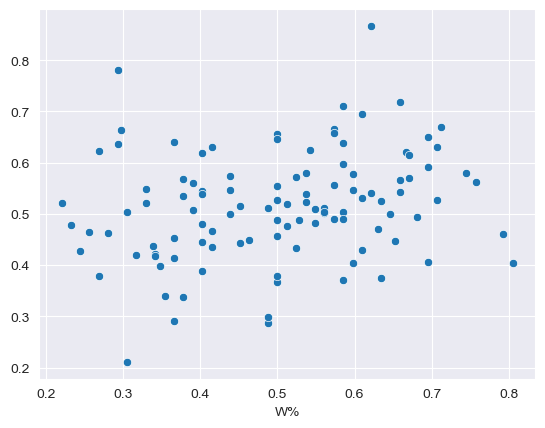

In [13]:
sns.scatterplot(x=y_test, y=y_pred)